In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('RegressorDataset.csv', index_col=[0], parse_dates=[0])
df

,LineLength,LocationId,MealType,MenuItem
Datetime,,,,
2018-08-28 12:21:00,150,Ford,Breakfast,Scrambled Eggs
2018-08-28 12:21:00,150,Ford,Breakfast,Scrambled Eggs w/Ham & Cheese
2018-08-28 12:21:00,150,Ford,Breakfast,Sweet Smoked Rope Sausage
2018-08-28 12:21:00,150,Ford,Breakfast,Pancakes
2018-08-28 12:21:00,150,Ford,Breakfast,Pancake Syrup Sugar Free
...,...,...,...,...
2017-11-02 17:58:00,200,Hillenbrand,Dinner,Tropical Fruit Salad
2017-11-02 17:58:00,200,Hillenbrand,Dinner,Shortbread Cookie
2017-11-02 17:58:00,200,Hillenbrand,Dinner,Chocolate Chip Cookie


df = pd.read_csv('WaitTimesRegression.csv', index_col=[0], parse_dates=[0])
df

In [3]:
#replace categorical columns with text with categorical column with numerical values

df.LocationId = pd.Categorical(df.LocationId)
df['LocationIdCode'] = df.LocationId.cat.codes
del df['LocationId']

df.MealType = pd.Categorical(df.MealType)
df['MealTypeCode'] = df.MealType.cat.codes
del df['MealType']

df.MenuItem = pd.Categorical(df.MenuItem)
df['MenuItemCode'] = df.MenuItem.cat.codes
del df['MenuItem']

In [4]:
df

,LineLength,LocationIdCode,MealTypeCode,MenuItemCode
Datetime,,,,
2018-08-28 12:21:00,150,1,0,2453
2018-08-28 12:21:00,150,1,0,2459
2018-08-28 12:21:00,150,1,0,2779
2018-08-28 12:21:00,150,1,0,1981
2018-08-28 12:21:00,150,1,0,1977
...,...,...,...,...
2017-11-02 17:58:00,200,2,1,2930
2017-11-02 17:58:00,200,2,1,2487
2017-11-02 17:58:00,200,2,1,711


color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = df.plot(style='.', figsize=(15,5), color=color_pal[0], title='Dining Court Wait-Times')

In [5]:
split_date = '01-Aug-2020'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

_ = df_test \
    .rename(columns={'LineLength': 'TEST SET'}) \
    .join(df_train.rename(columns={'LineLength': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Dining Court Wait-Times', style='.')

In [6]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    print(df)
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['hour','dayofweek','quarter','month','year',
        'dayofyear','dayofmonth','weekofyear', 'LocationIdCode', 'MealTypeCode', 'MenuItemCode']]
    
    print(X)
    if label:
        y = df[label]
        return X, y
    return X

In [7]:
X_train, y_train = create_features(df_train, label='LineLength')
X_test, y_test = create_features(df_test, label='LineLength')


                     LineLength  LocationIdCode  MealTypeCode  MenuItemCode
Datetime                                                                   
2018-08-28 12:21:00         150               1             0          2453
2018-08-28 12:21:00         150               1             0          2459
2018-08-28 12:21:00         150               1             0          2779
2018-08-28 12:21:00         150               1             0          1981
2018-08-28 12:21:00         150               1             0          1977
...                         ...             ...           ...           ...
2017-11-02 17:58:00         200               2             1          2930
2017-11-02 17:58:00         200               2             1          2487
2017-11-02 17:58:00         200               2             1           711
2017-11-02 17:58:00         200               2             1          1567
2017-11-02 17:58:00         200               2             1          2246

[178095 row

<ipython-input-6-0d987608ff4c>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-6-0d987608ff4c>:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


In [27]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [28]:
y_pred_1_ini = reg.predict(X_test)

In [29]:
y_pred_1_ini

array([ 99.75101,  99.75101,  99.75101, ..., 103.02436, 103.02436,
       103.02436], dtype=float32)

In [33]:
y_test.to_numpy()

array([150, 150, 150, ..., 200, 200, 200], dtype=int64)

In [35]:
residuals_1_ini = y_test.to_numpy() – y_pred_1_ini

residuals_1_ini

print(“Residuals_ini Mean:”, round(residuals_1_ini.mean(),4))

print(“Residuals_ini Sigma:”, round(residuals_1_ini.std(),4))

SyntaxError: invalid character in identifier (<ipython-input-35-c30e7c366549>, line 1)

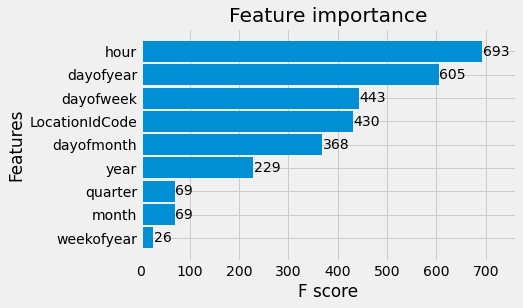

In [24]:
_ = plot_importance(reg, height=0.9)

In [10]:
df_test['LineLengthPrediction'] = reg.predict(X_test)
df_all = pd.concat([df_test, df_train], sort=False)

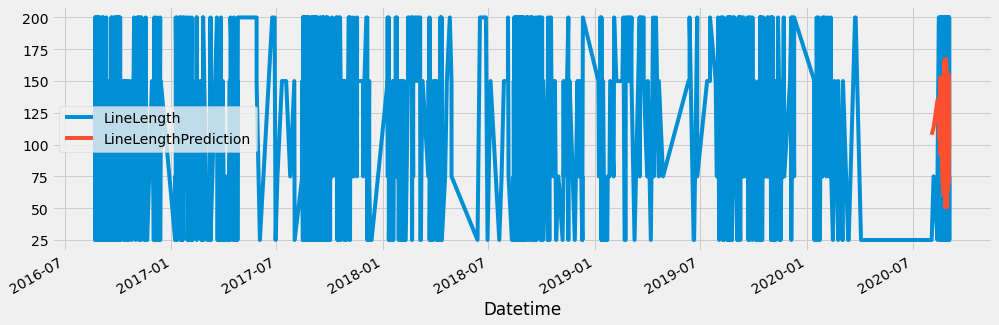

In [11]:
_ = df_all[['LineLength','LineLengthPrediction']].plot(figsize=(15, 5))

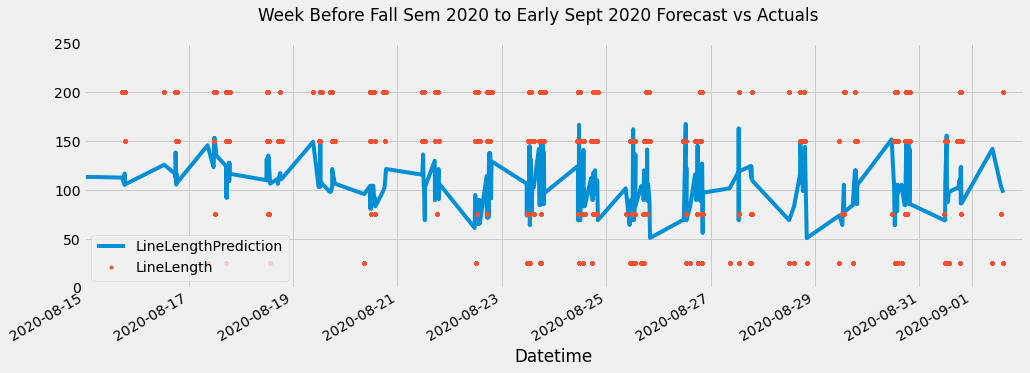

In [13]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-15-2020', upper='09-02-2020')
plot = plt.suptitle('Week Before Fall Sem 2020 to Early Sept 2020 Forecast vs Actuals')

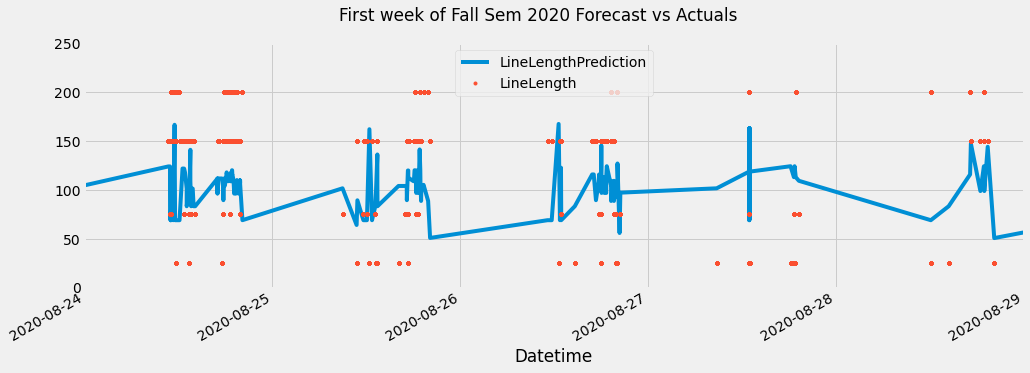

In [14]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-24-2020', upper='08-29-2020')
plot = plt.suptitle('First week of Fall Sem 2020 Forecast vs Actuals')

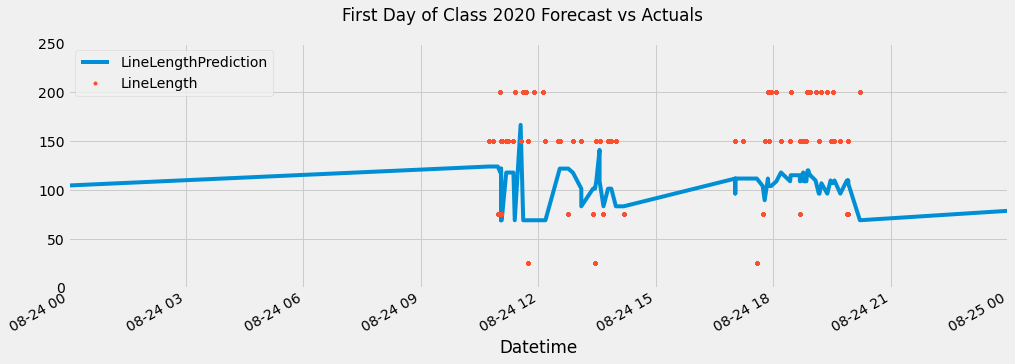

In [15]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-24-2020', upper='08-25-2020')
plot = plt.suptitle('First Day of Class 2020 Forecast vs Actuals')

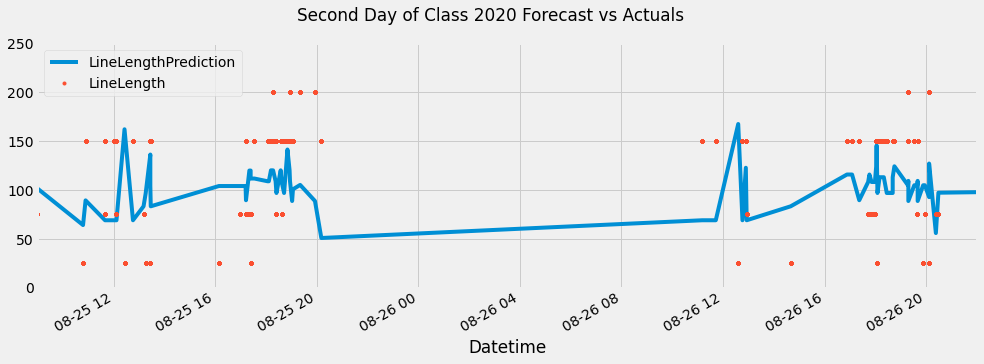

In [16]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-25-2020 09', upper='08-26-2020 22')
plot = plt.suptitle('Second Day of Class 2020 Forecast vs Actuals')

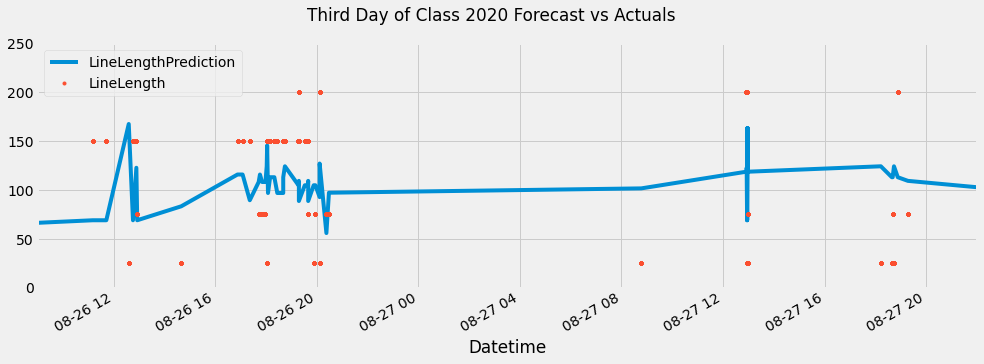

In [17]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df_all[['LineLengthPrediction','LineLength']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 250)
ax.set_xbound(lower='08-26-2020 09', upper='08-27-2020 22')
plot = plt.suptitle('Third Day of Class 2020 Forecast vs Actuals')

In [18]:
#create a function that takes in the date, dining court, menu item? return plot. build ui next sprint.